### Solar Phase Angle vs. Brightness Plot
This code reads the Pomenis observation database and creates a plot
of AB Magnitude vs. Solar Phase Angle

In [1]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import numpy as np
import lumos.calculator
import lumos.conversions
import satellite_models.starlink_v1p5 as starlink_v1p5


In [2]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import numpy as np
import lumos.calculator
import lumos.conversions
import satellite_models.starlink_v1p5 as starlink_v1p5


In [2]:
# Read observer frame results
data_path = r'...\NewCode\filtered_observer_frame_results.csv'
data = pd.read_csv(data_path)

# Set constants and get data from CSV
satellite_height = 550 * 1000  # 550 km in meters
satellite_altitudes = data['sat_alt'].to_numpy()  # Satellite altitude in degrees
satellite_azimuths = data['sat_az'].to_numpy()   # Satellite azimuth in degrees
sun_altitudes = data['sun_alt'].to_numpy()       # Sun altitude in degrees
sun_azimuths = data['sun_az'].to_numpy()         # Sun azimuth in degrees
solar_phase_angles = data['phase_angle'].to_numpy()  # Already in degrees

# Keep only data where the sun is below the horizon (sun_alt < 0)
night_data = data[data['sun_alt'] < 0].copy()

# These will be calculated later

measured_magnitudes = np.zeros_like(solar_phase_angles)  # Placeholder for magnitude calculations

In [3]:
# Calculate magnitudes for each observation with effective areas from the data
surfaces = starlink_v1p5.SURFACES_LAB_BRDFS  # This will be modified per observation
calculated_magnitudes = []

for i, row in night_data.iterrows():
    # Get effective areas for this observation
    effective_chassis_area = row['A_eff_chassis']
    effective_solar_array_area = row['A_eff_SA']

    # Modify the surface areas in the BRDF model
    modified_surfaces = [
        starlink_v1p5.Surface(effective_chassis_area, surfaces[0].normal, surfaces[0].brdf),
        starlink_v1p5.Surface(effective_solar_array_area, surfaces[1].normal, surfaces[1].brdf)
    ]

    intensity = lumos.calculator.get_intensity_observer_frame(
        modified_surfaces,
        satellite_height,
        np.array([row['sat_alt']]),
        np.array([row['sat_az']]),
        row['sun_alt'],
        row['sun_az'],
        include_sun=True,
        include_earthshine=False,
        earth_panel_density=251
    )
    mag = lumos.conversions.intensity_to_ab_mag(intensity)
    calculated_magnitudes.append(mag[0])  # Get scalar value from array

calculated_magnitudes = np.array(calculated_magnitudes)

In [4]:
# Add calculation results to the nighttime data DataFrame
night_data['calculated_mag'] = calculated_magnitudes

# Select columns to save (can be adjusted as needed)
columns_to_save = ['sun_alt', 'sun_az', 'sat_alt', 'sat_az',
                   'phase_angle', 'calculated_mag']

# Save to a new CSV file
output_path = r'...\NewCode\MagnitudesCalculation_1.csv'
night_data[columns_to_save].to_csv(output_path, index=False)

# Filter data where satellite is actually visible (magnitude != 12.5)
visible_data = night_data[night_data['calculated_mag'] < 10].copy()

# Save visible satellite data to separate CSV
output_path_visible = r'...\NewCode\MagnitudesCalculation_Visible_1.csv'
visible_data[columns_to_save].to_csv(output_path_visible, index=False)

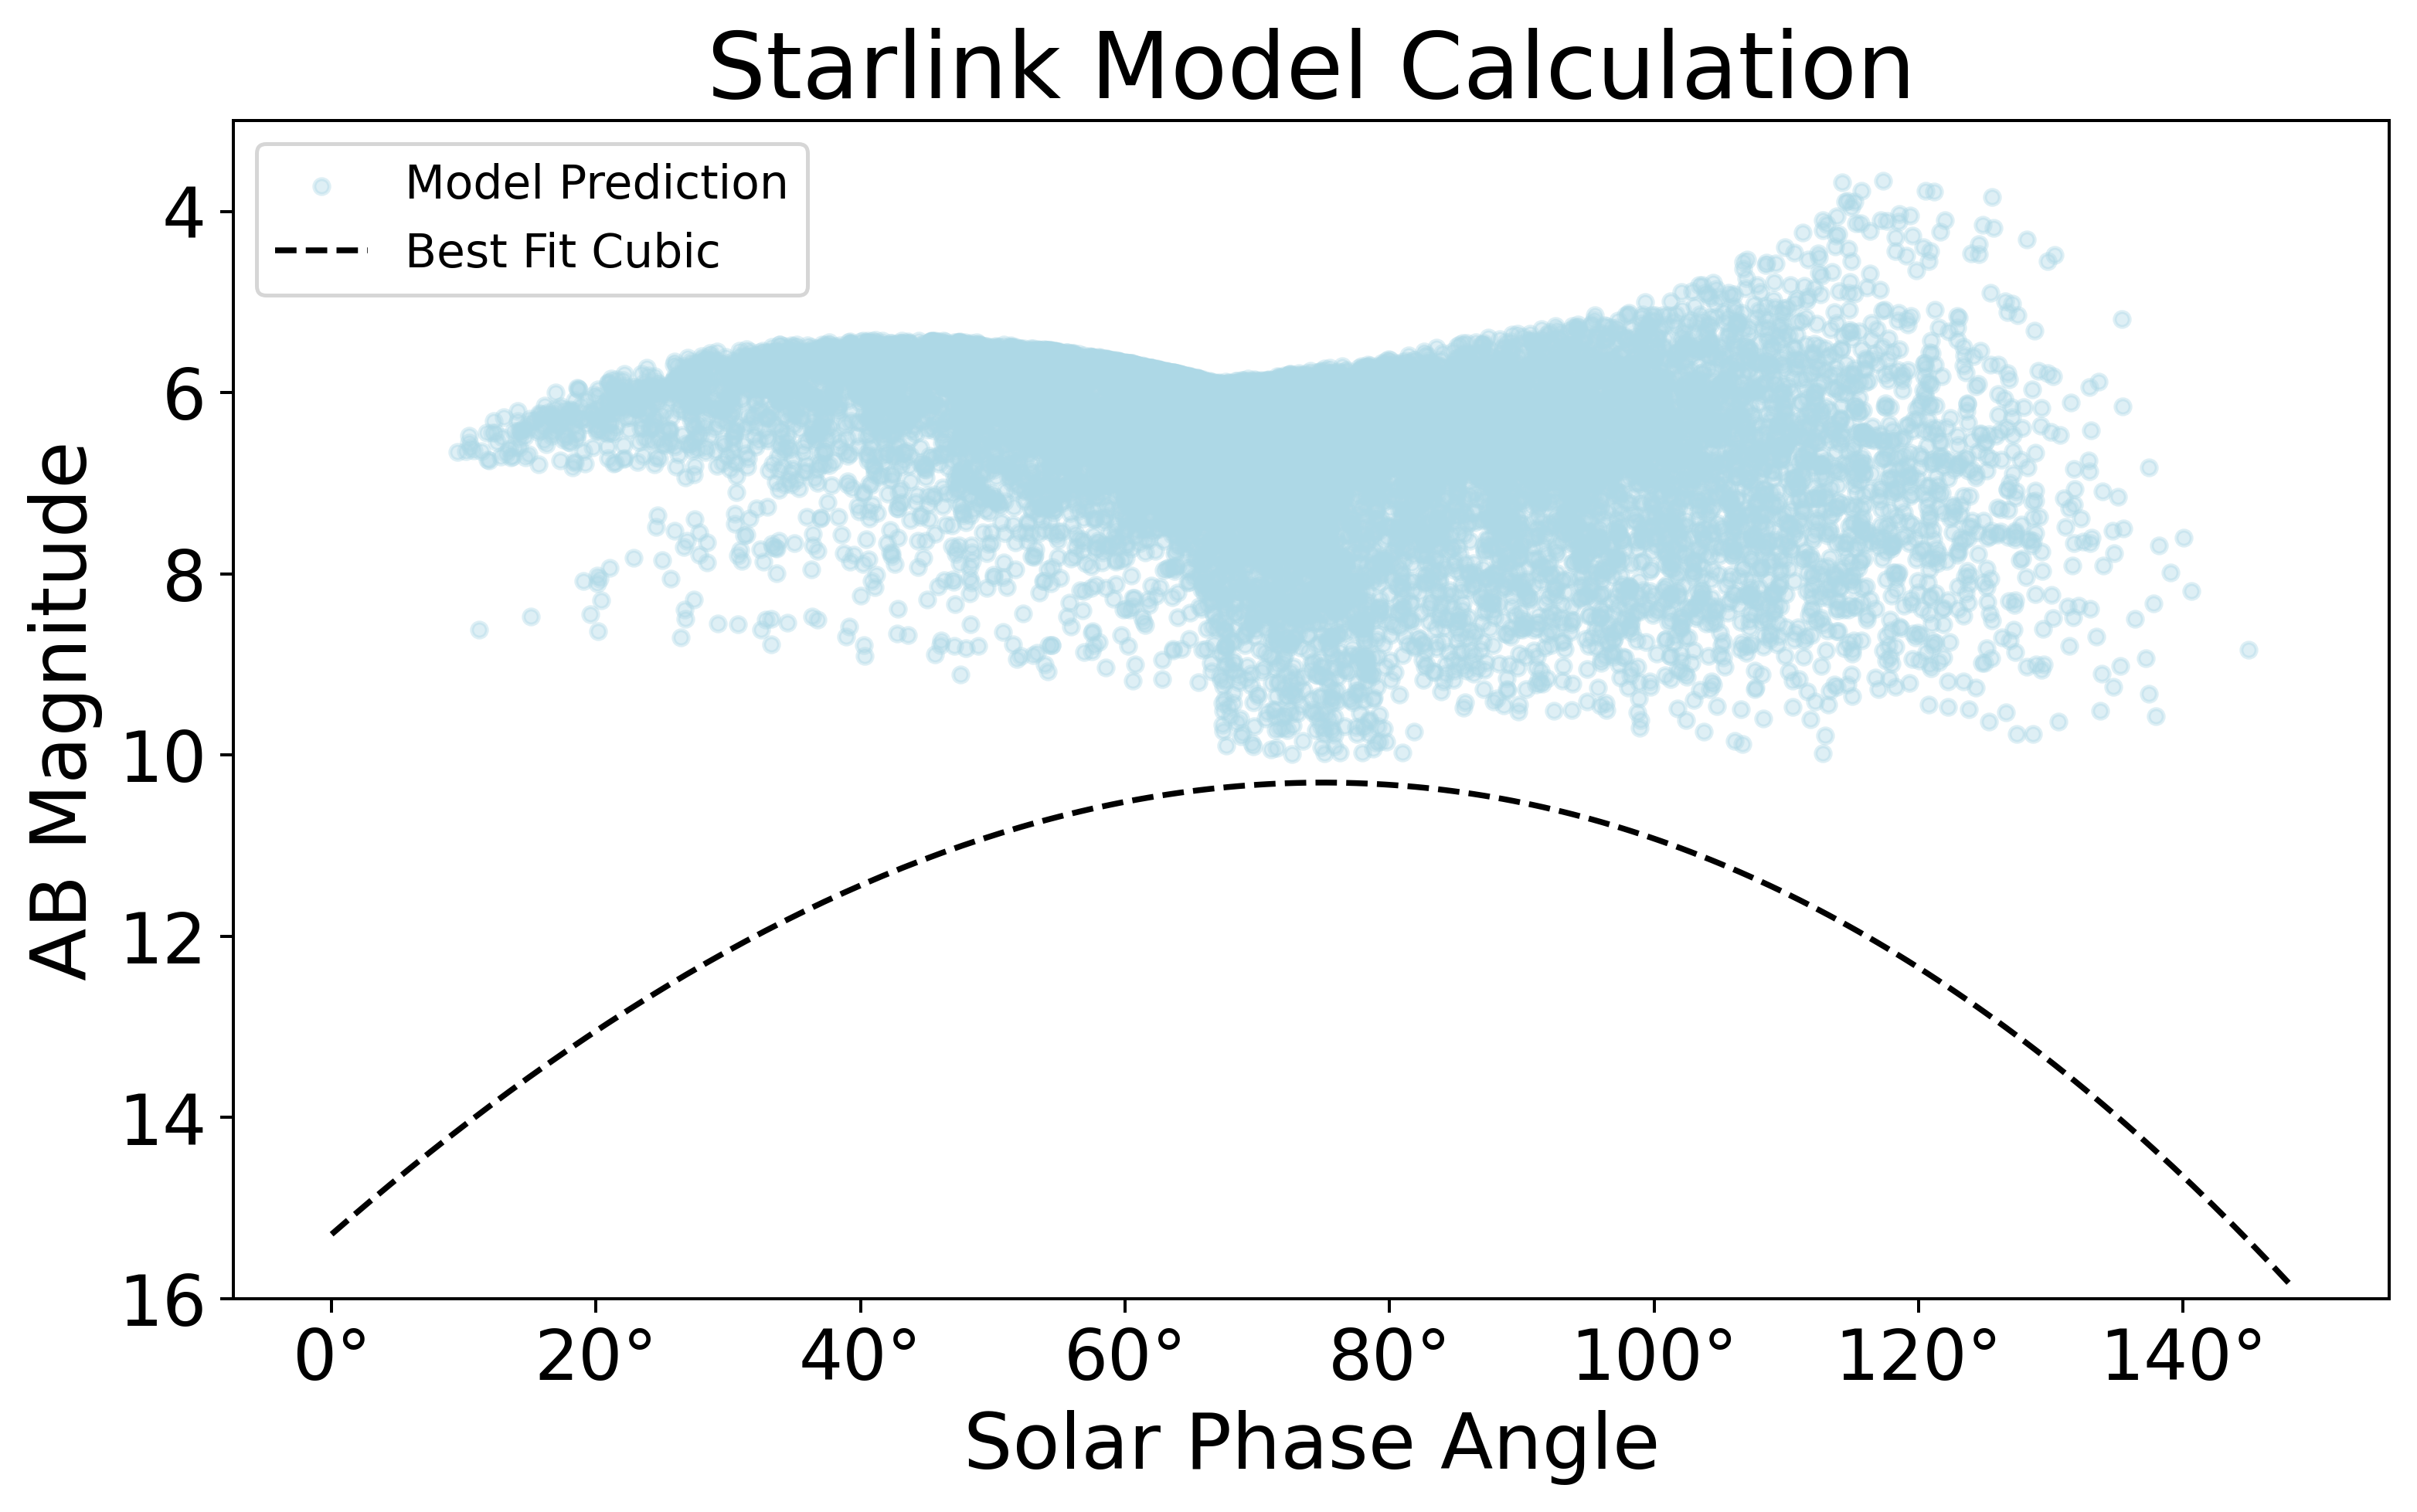

In [5]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5.5), dpi=360)

# Configure plot axes and labels
ax.set_ylim(3, 16)
ax.invert_yaxis()  # Reverse y-axis since magnitude scale decreases with brightness
ax.set_xlabel("Solar Phase Angle", fontsize=20)
ax.set_ylabel("AB Magnitude", fontsize=20)
ax.set_title("Starlink Model Calculation", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))  # Format x-axis as degrees

# Plot calculated magnitudes against phase angles
ax.scatter(visible_data['phase_angle'], visible_data['calculated_mag'],
           alpha=0.4, s=15, label="Model Prediction", color='lightblue')

# Add best-fit cubic polynomial if we have enough data points
if len(night_data) >= 4:  # Need at least 4 points for cubic fit
    a1, a2, a3, a4 = np.polyfit(night_data['phase_angle'],
                               calculated_magnitudes, deg=3)
    x = np.linspace(night_data['phase_angle'].min(),
                   night_data['phase_angle'].max(), 200)  # Smooth curve
    y = a1*x**3 + a2*x**2 + a3*x + a4
    ax.plot(x, y, "--k", label="Best Fit Cubic")

# Add legend and display plot
ax.legend(loc=2, prop={'size': 12})
plt.show()

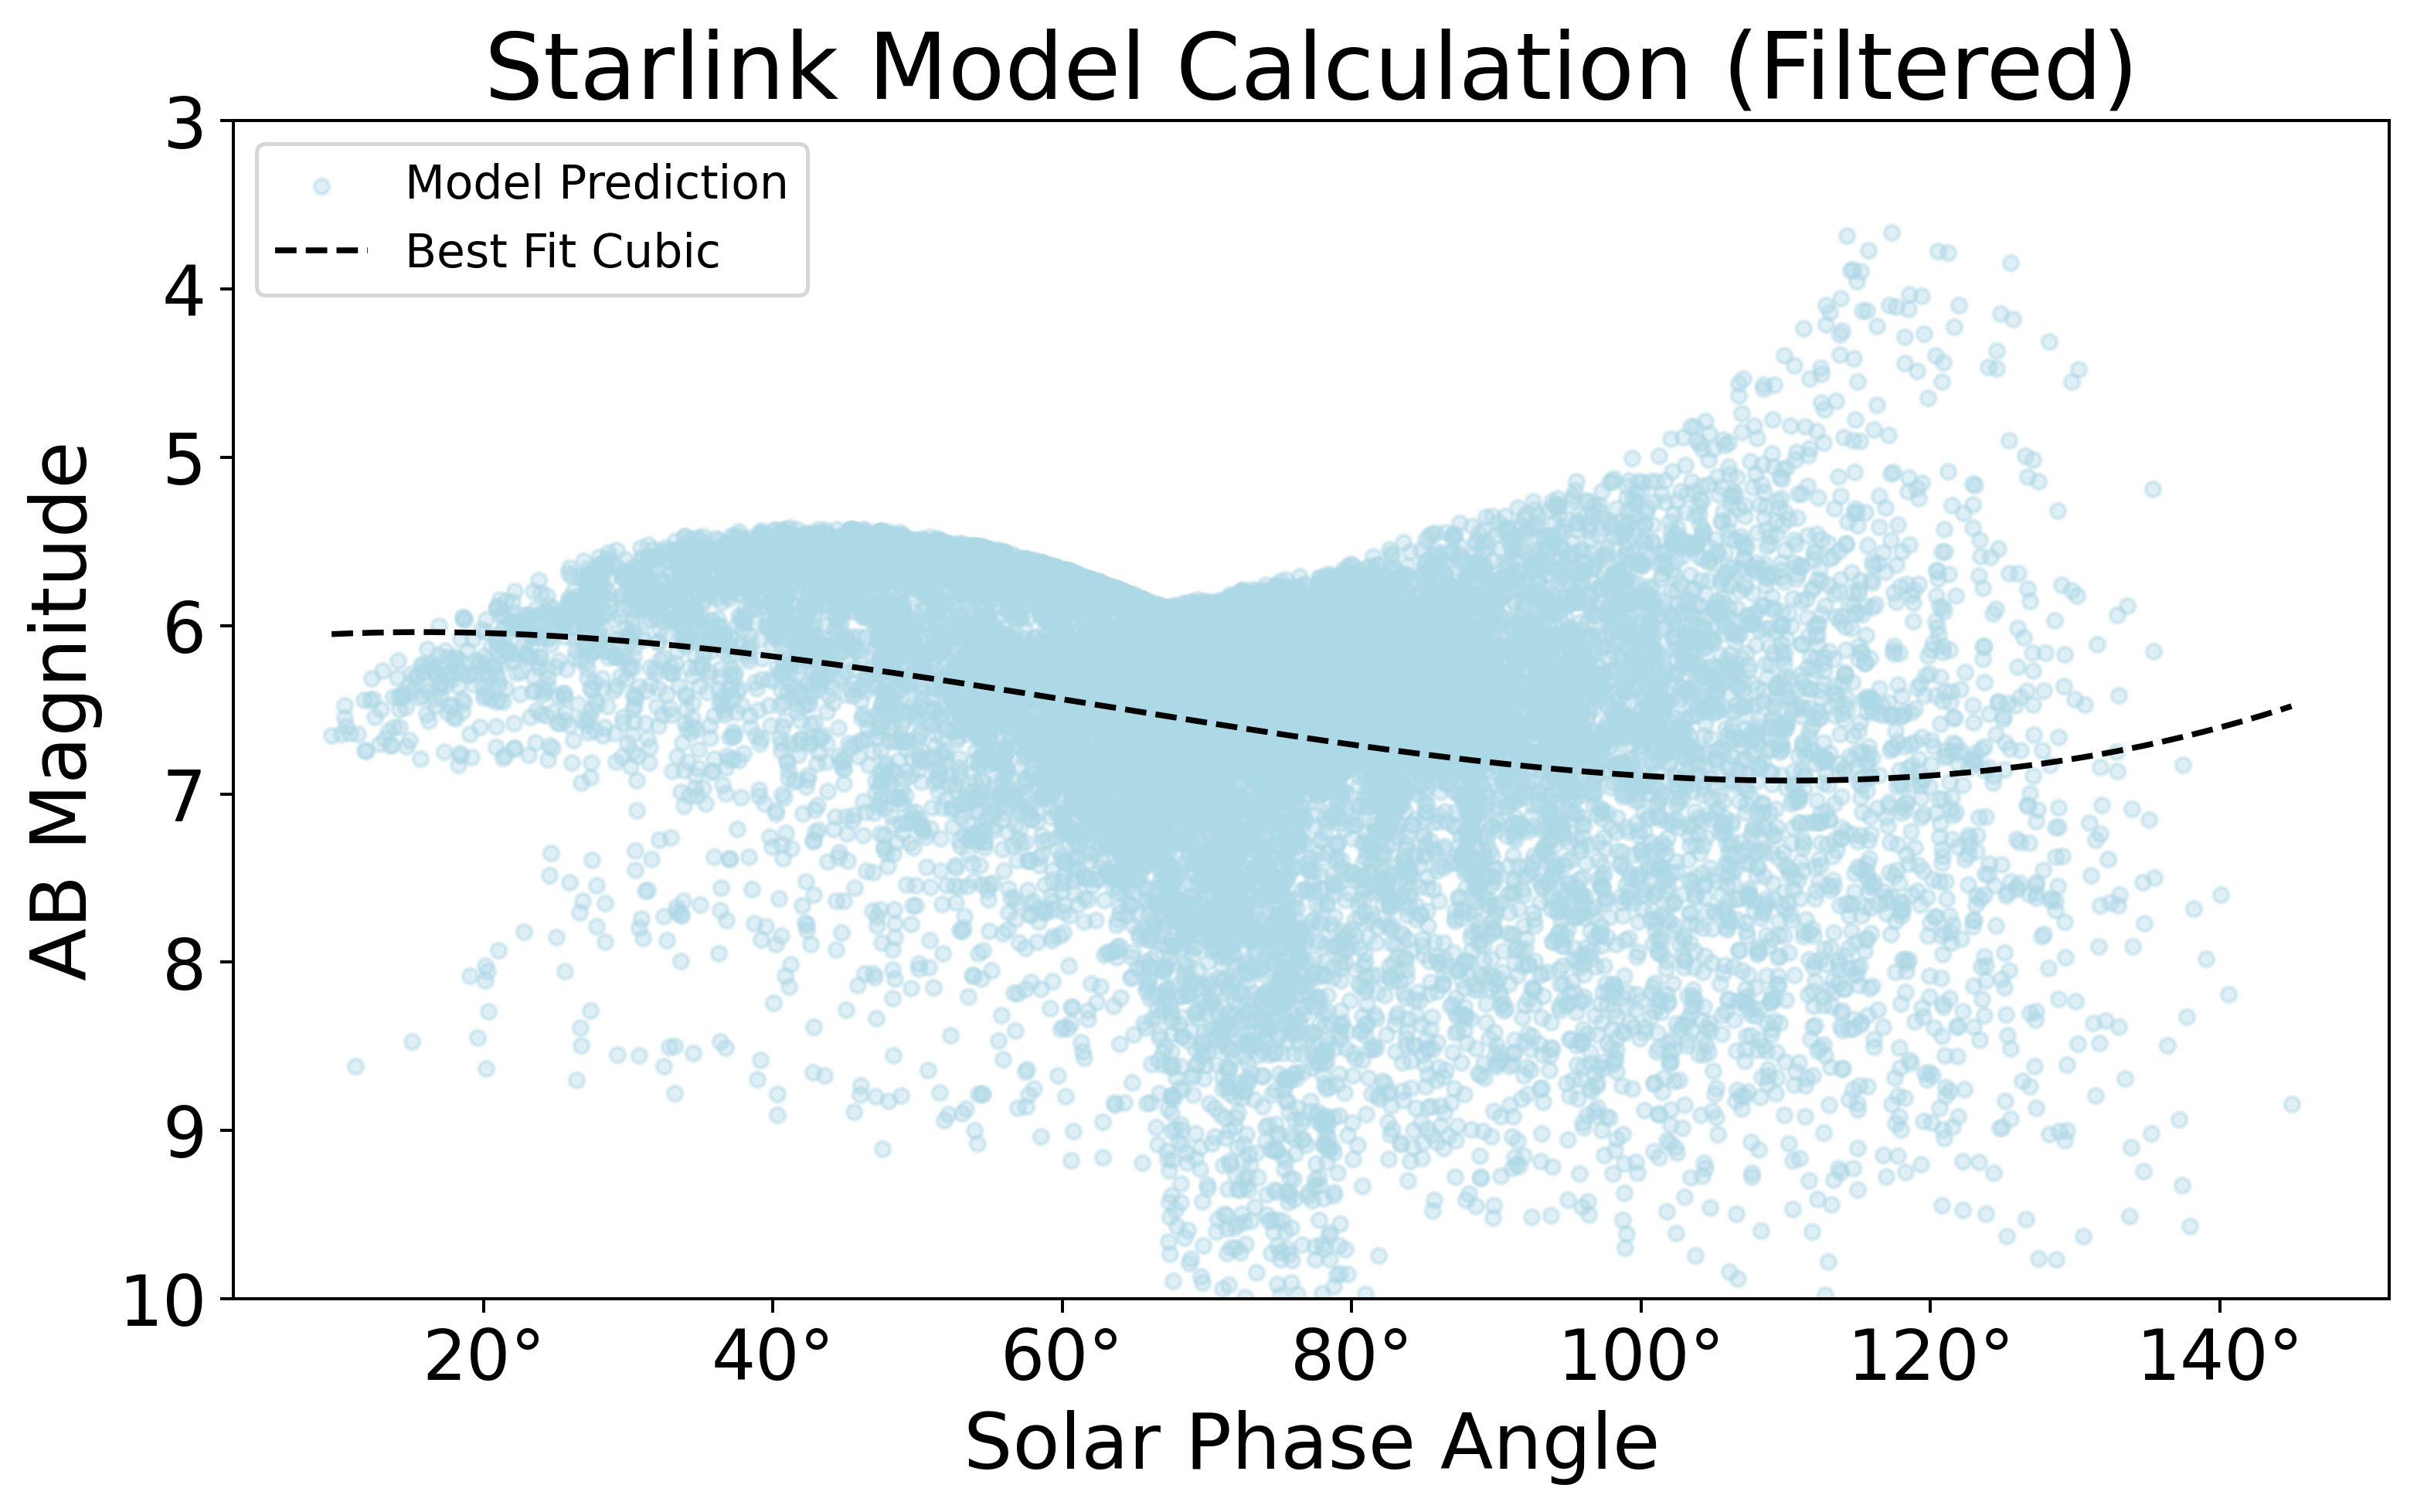

In [6]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5.5), dpi=360)

# Load filtered visible satellite data
visible_data_path = r'...\NewCode\MagnitudesCalculation_Visible_1.csv'
visible_data = pd.read_csv(visible_data_path)

# Configure plot settings (consistent with original plot)
ax.set_ylim(3, 10)
ax.invert_yaxis()  # Magnitude scale convention (brighter objects have lower values)
ax.set_xlabel("Solar Phase Angle", fontsize=20)
ax.set_ylabel("AB Magnitude", fontsize=20)
ax.set_title("Starlink Model Calculation (Filtered)", fontsize=24)  # Note: Added 'Filtered' to title
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))  # Format x-axis labels in degrees

# Plot filtered visible data points
ax.scatter(visible_data['phase_angle'], visible_data['calculated_mag'],
           alpha=0.4, s=15, label="Model Prediction", color='lightblue')  # Updated legend label

# Calculate and plot best-fit cubic polynomial (using filtered data)
if len(visible_data) >= 4:  # Minimum 4 points required for cubic fit
    a1, a2, a3, a4 = np.polyfit(visible_data['phase_angle'],
                               visible_data['calculated_mag'], deg=3)
    x = np.linspace(visible_data['phase_angle'].min(),
                   visible_data['phase_angle'].max(), 200)  # Generate smooth curve
    y = a1*x**3 + a2*x**2 + a3*x + a4
    ax.plot(x, y, "--k", label="Best Fit Cubic")  # Updated legend label

# Add legend and display plot
ax.legend(loc=2, prop={'size': 12})  # Legend in upper left corner
plt.show()

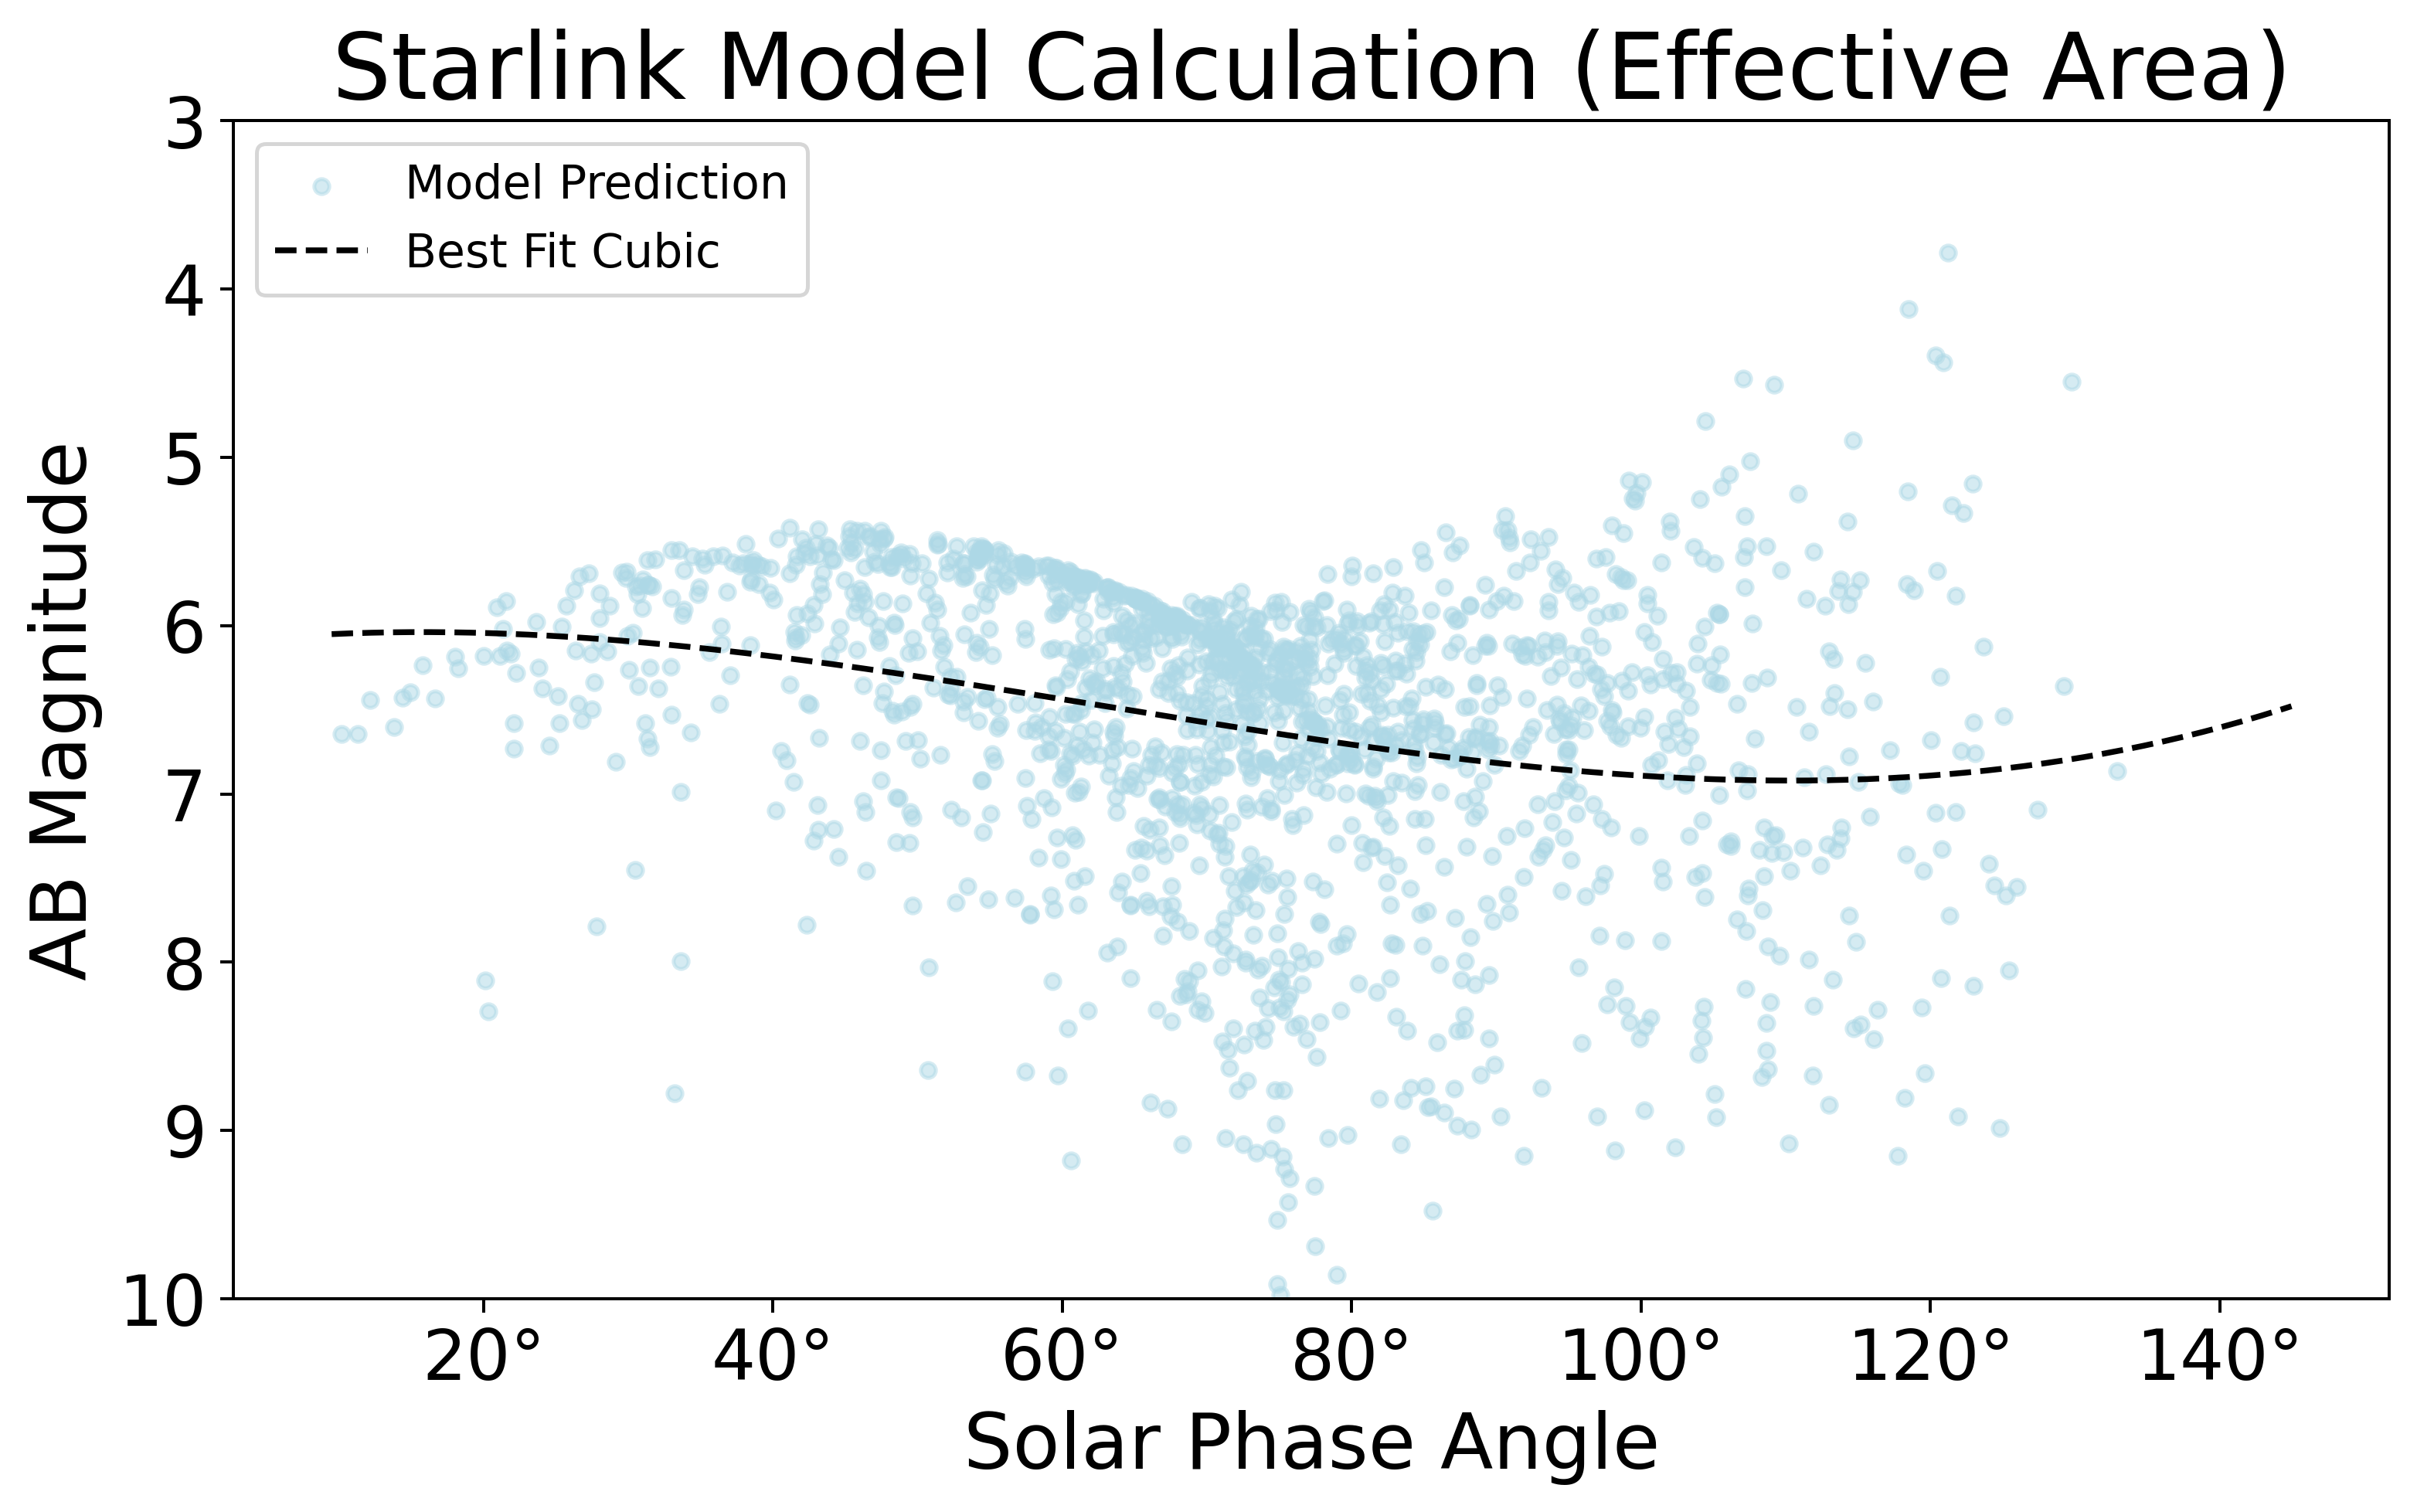

-2.0853099419141134e-06 0.0003942665686926047 -0.010856206667044512 6.119578755867253


In [26]:
# Initialize plot with high resolution
fig, ax = plt.subplots(1, 1, figsize=(10, 5.5), dpi=360)

# Load filtered visible satellite data
visible_data_path = r'...\NewCode\MagnitudesCalculation_Visible_1.csv'
visible_data = pd.read_csv(visible_data_path)

# Create decimated dataset (select every 10th row starting from index 9)
decimated_data = visible_data.iloc[9::10].copy()  # Using 0-based indexing (rows 9,19,29...)

# Configure plot settings
ax.set_ylim(3, 10)
ax.invert_yaxis()  # Standard astronomical magnitude convention
ax.set_xlabel("Solar Phase Angle", fontsize=20)
ax.set_ylabel("AB Magnitude", fontsize=20)
ax.set_title("Starlink Model Calculation (Effective Area)", fontsize=24)  # Note sampling rate
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))  # Degree formatting

# Plot decimated data points with adjusted visual parameters
ax.scatter(decimated_data['phase_angle'], decimated_data['calculated_mag'],
           alpha=0.5, s=15, label="Model Prediction", color='lightblue')  # Increased visibility

# Calculate and plot best-fit cubic polynomial (using full dataset for smoothness)
if len(visible_data) >= 4:  # Minimum points for cubic fit
    a1, a2, a3, a4 = np.polyfit(visible_data['phase_angle'],
                               visible_data['calculated_mag'], deg=3)
    x = np.linspace(visible_data['phase_angle'].min(),
                   visible_data['phase_angle'].max(), 200)  # Smooth curve
    y = a1*x**3 + a2*x**2 + a3*x + a4
    ax.plot(x, y, "--k", label="Best Fit Cubic")  # Clarify data source

# Add legend and display plot
ax.legend(loc=2, prop={'size': 12})  # Upper left position
plt.show()
print(a1, a2, a3,a4)

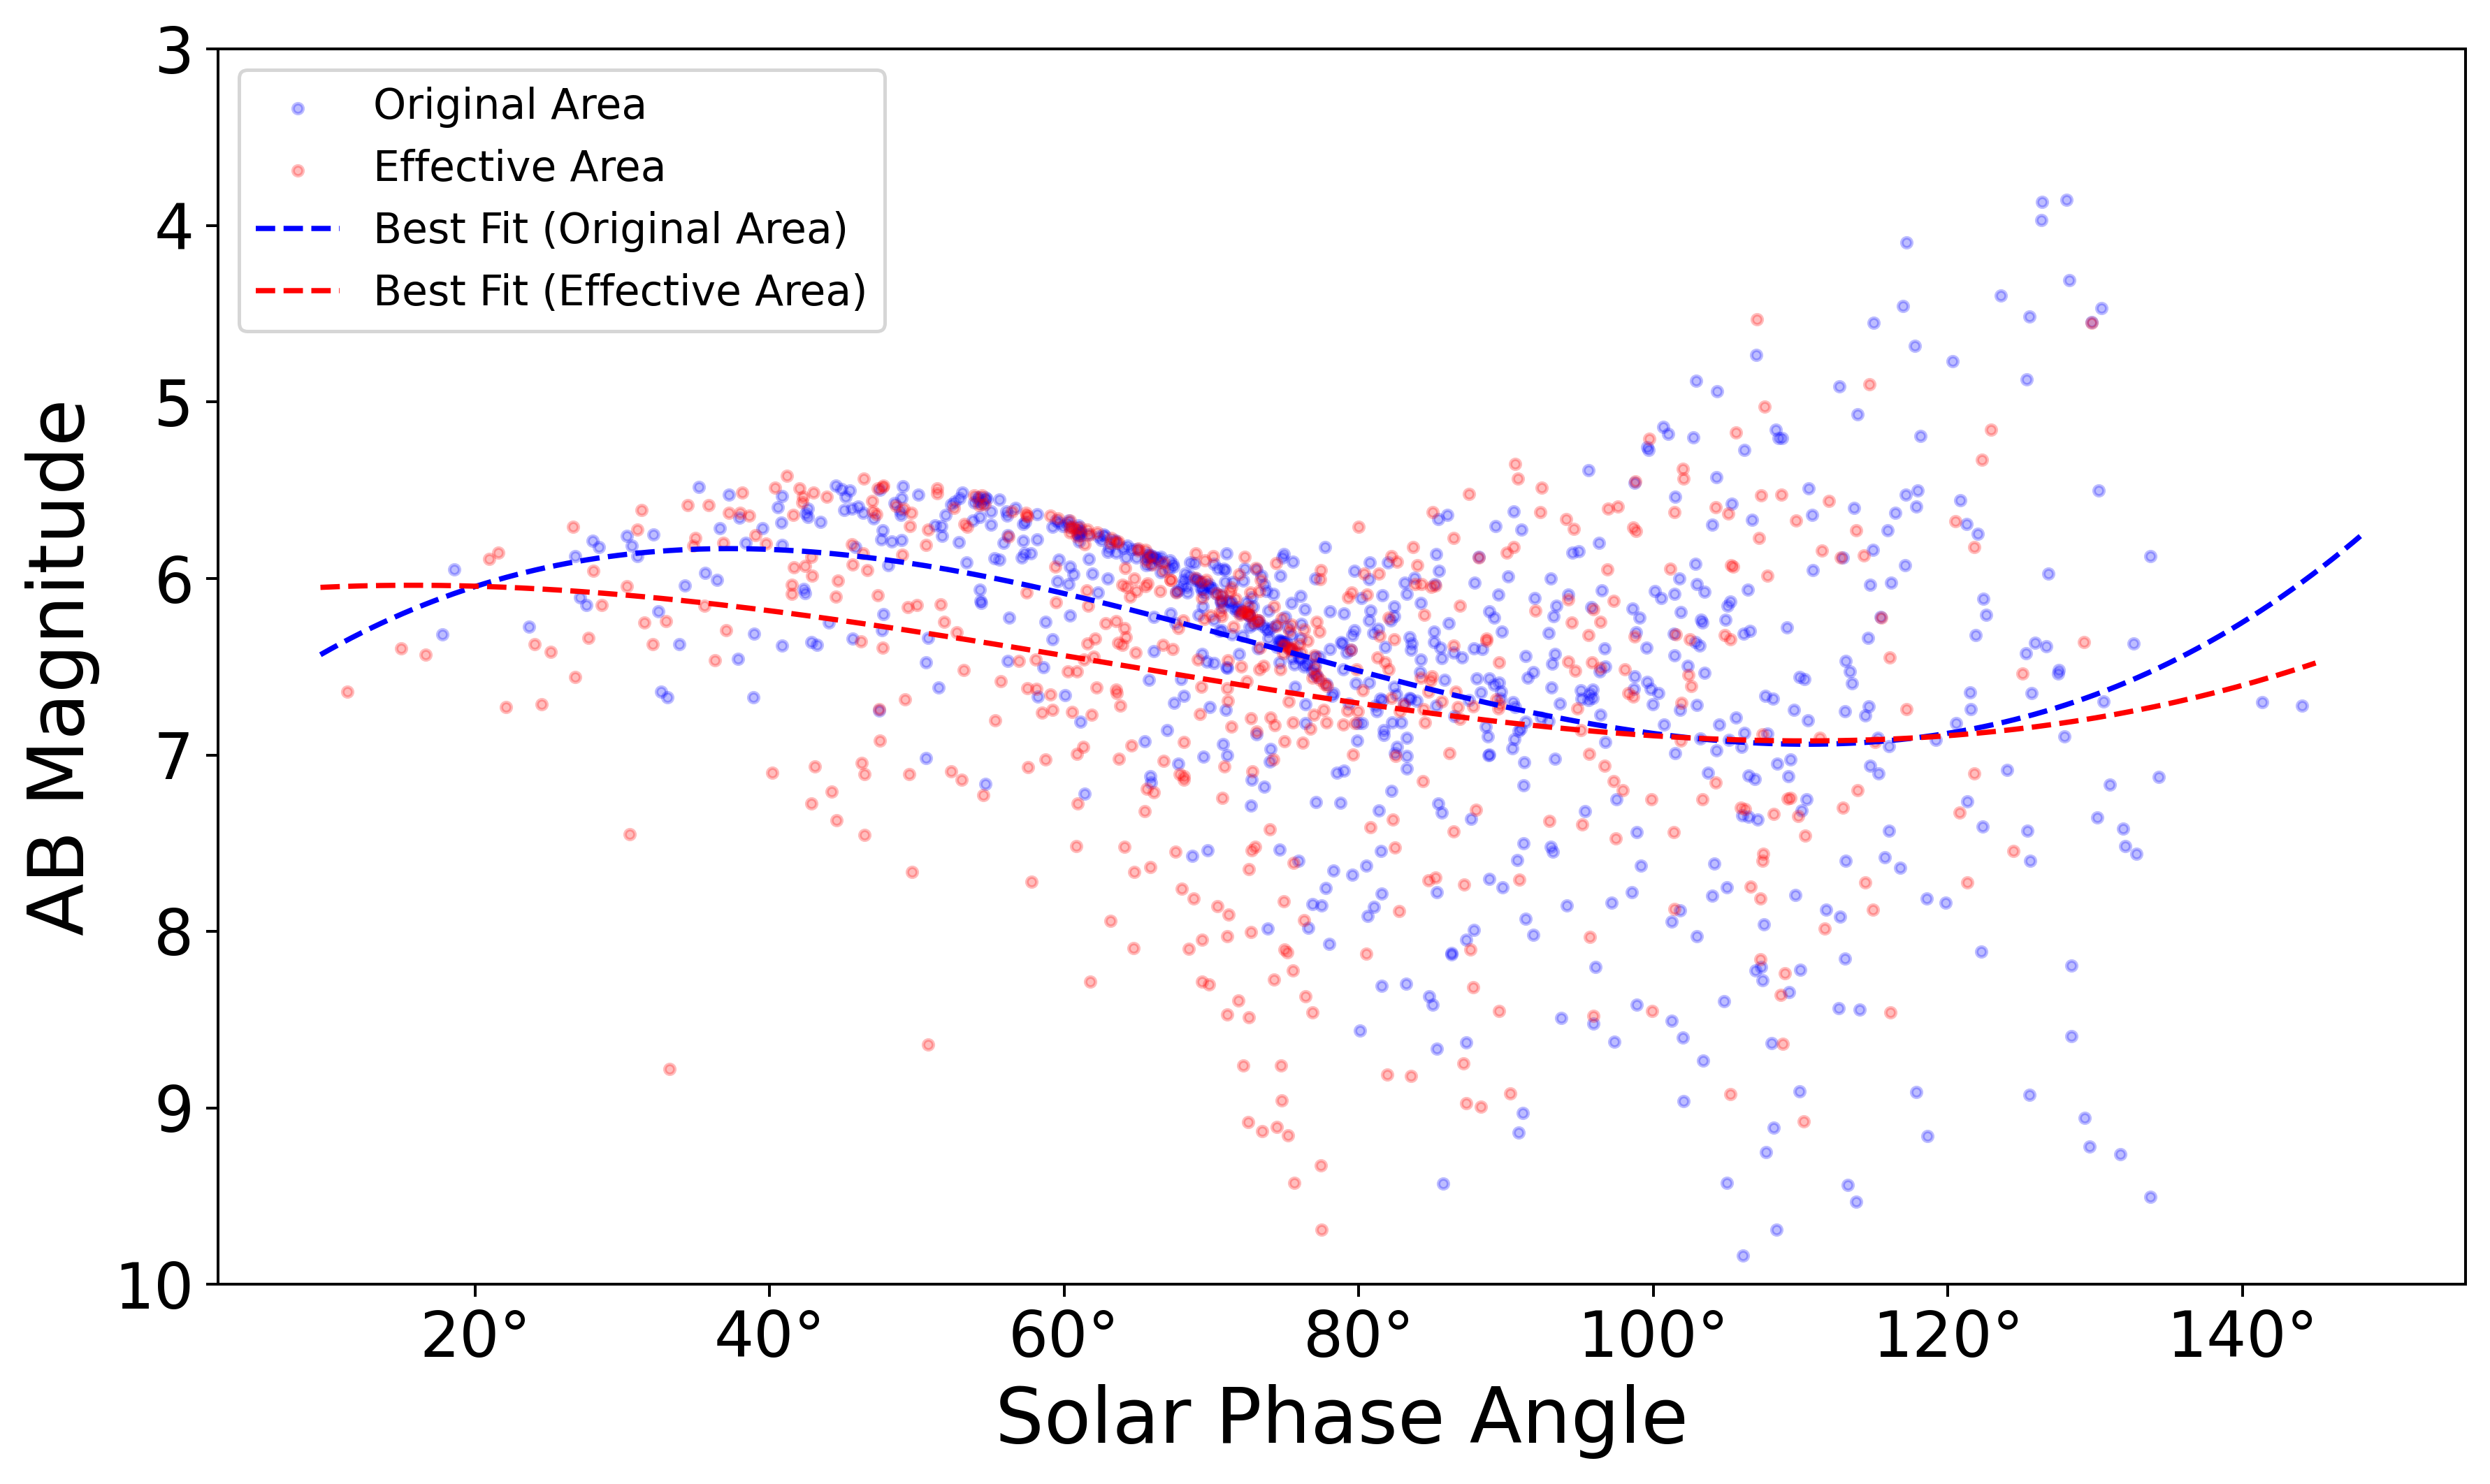

In [5]:

# Initialize plot with high resolution
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=360)

# Load both datasets
original_path = r'...\NewCode\MagnitudesCalculationOrigin_Visible.csv'
effective_path = r'...\NewCode\MagnitudesCalculation_Visible_1.csv'

original_data = pd.read_csv(original_path)
effective_data = pd.read_csv(effective_path)

# Create decimated datasets (select every 100th row for 1% sampling)
decimated_original = original_data.iloc[29::30].copy()  # 1% sampling (0-based index: 99,199,299...)
decimated_effective = effective_data.iloc[29::30].copy()

# Configure plot settings
ax.set_ylim(3, 10)
ax.invert_yaxis()  # Standard astronomical magnitude convention
ax.set_xlabel("Solar Phase Angle", fontsize=22)
ax.set_ylabel("AB Magnitude", fontsize=22)
#ax.set_title("Starlink Model Comparison", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))  # Degree formatting

# Plot decimated data points with different colors
ax.scatter(decimated_original['phase_angle'], decimated_original['calculated_mag'],
           alpha=0.26, s=8, label="Original Area ", color='blue')
ax.scatter(decimated_effective['phase_angle'], decimated_effective['calculated_mag'],
           alpha=0.26, s=8, label="Effective Area ", color='red')

# Calculate and plot best-fit cubic polynomials for both datasets
def plot_best_fit(data, color, label):
    if len(data) >= 4:  # Minimum points for cubic fit
        a1, a2, a3, a4 = np.polyfit(data['phase_angle'], data['calculated_mag'], deg=3)
        x = np.linspace(data['phase_angle'].min(), data['phase_angle'].max(), 200)
        y = a1*x**3 + a2*x**2 + a3*x + a4
        ax.plot(x, y, "--", color=color, label=label)

plot_best_fit(original_data, 'blue', "Best Fit (Original Area)")
plot_best_fit(effective_data, 'red', "Best Fit (Effective Area)")

# Add legend and display plot
ax.legend(loc=2, prop={'size': 12})  # Upper left position
plt.tight_layout()  # Prevent label cutoff
plt.show()